In [1]:
#Setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, precision_recall_curve, average_precision_score,
    matthews_corrcoef, cohen_kappa_score
)
from sklearn.base import BaseEstimator, ClassifierMixin


In [2]:
# Generate Data

# Set random seed for reproducibility
np.random.seed(0)

# Number of data points
num_points = 1000

# Setpoint temperature and buffers
T_set = 150
Buffer_low = -5
Buffer_high = 5

# Generate normal and anomalous temperature data
T_data_normal = T_set + np.random.randn(num_points)
T_data_anomalous = T_set + 15 + np.random.randn(int(num_points * 0.1))
T_data = np.concatenate([T_data_normal, T_data_anomalous])

# Baseline power consumption and threshold
P_base = 500
Delta_P_threshold = 50

# Generate normal and anomalous power consumption data
P_data_normal = P_base + 10 * np.random.randn(num_points)
P_data_anomalous = P_base + 100 + 10 * np.random.randn(int(num_points * 0.1))
P_data = np.concatenate([P_data_normal, P_data_anomalous])

# Combine temperature and power data into a single dataset
data = np.vstack((T_data, P_data)).T

# Create labels for normal (1) and anomalous (-1) data
labels = np.ones(len(data))
labels[-len(T_data_anomalous):] = -1


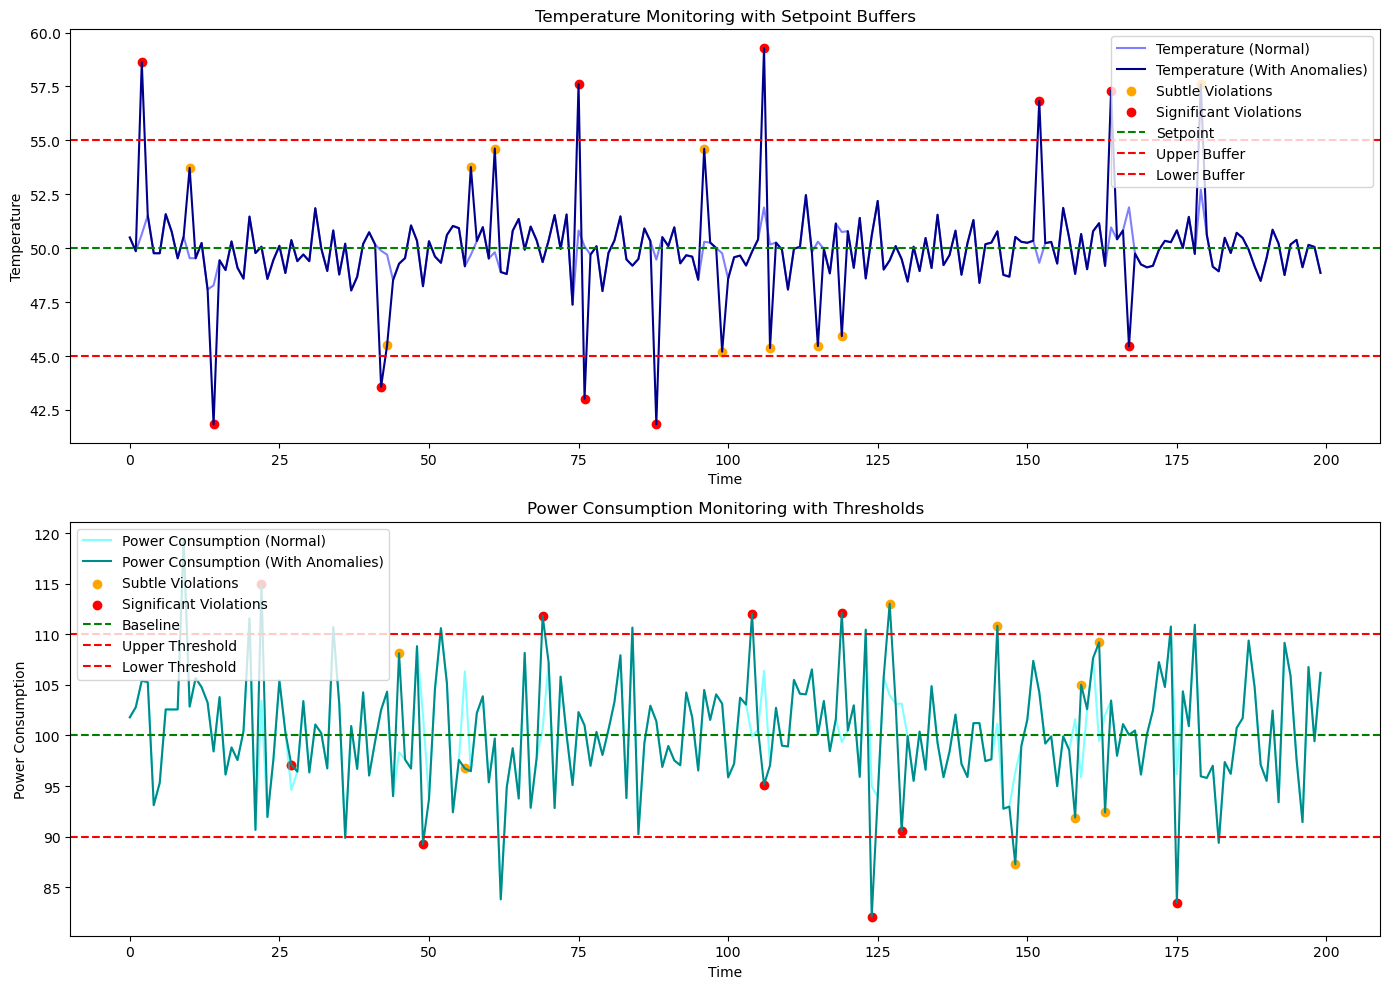

In [3]:
 #Setpoint Buffering Simulation

import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(42)  # for reproducibility
time_steps = 200
T_set = 50
Buffer_high = 5
Buffer_low = 5
P_base = 100
Delta_P_threshold = 10

# Generate synthetic data for normal operation
T_data_normal = T_set + np.random.normal(0, 1, time_steps)
P_data_normal = P_base + np.random.normal(0, 5, time_steps)

# Copy data for introducing anomalies
T_data = np.copy(T_data_normal)
P_data = np.copy(P_data_normal)

# Inject subtle violations within the buffer zone
subtle_violation_indices_T = np.random.choice(time_steps, size=10, replace=False)
subtle_violation_indices_P = np.random.choice(time_steps, size=10, replace=False)

T_data[subtle_violation_indices_T[:5]] += Buffer_high - np.random.uniform(0.1, 1, 5)
T_data[subtle_violation_indices_T[5:]] -= Buffer_low - np.random.uniform(0.1, 1, 5)

P_data[subtle_violation_indices_P[:5]] += Delta_P_threshold - np.random.uniform(0.1, 1, 5)
P_data[subtle_violation_indices_P[5:]] -= Delta_P_threshold - np.random.uniform(0.1, 1, 5)

# Inject significant violations beyond the buffer zone
significant_violation_indices_T = np.random.choice(time_steps, size=10, replace=False)
significant_violation_indices_P = np.random.choice(time_steps, size=10, replace=False)

T_data[significant_violation_indices_T[:5]] += Buffer_high + np.random.uniform(1, 3, 5)
T_data[significant_violation_indices_T[5:]] -= Buffer_low + np.random.uniform(1, 3, 5)

P_data[significant_violation_indices_P[:5]] += Delta_P_threshold + np.random.uniform(1, 3, 5)
P_data[significant_violation_indices_P[5:]] -= Delta_P_threshold + np.random.uniform(1, 3, 5)

# Plot temperature data with setpoint buffers
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.plot(T_data_normal, label='Temperature (Normal)', color='blue', alpha=0.5)
plt.plot(T_data, label='Temperature (With Anomalies)', color='darkblue')

# Highlight subtle and significant violations
plt.scatter(subtle_violation_indices_T, T_data[subtle_violation_indices_T], color='orange', label='Subtle Violations')
plt.scatter(significant_violation_indices_T, T_data[significant_violation_indices_T], color='red', label='Significant Violations')

plt.axhline(T_set, color='green', linestyle='--', label='Setpoint')
plt.axhline(T_set + Buffer_high, color='red', linestyle='--', label='Upper Buffer')
plt.axhline(T_set - Buffer_low, color='red', linestyle='--', label='Lower Buffer')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Monitoring with Setpoint Buffers')
plt.legend()

# Plot power consumption data with baseline and thresholds
plt.subplot(2, 1, 2)
plt.plot(P_data_normal, label='Power Consumption (Normal)', color='cyan', alpha=0.5)
plt.plot(P_data, label='Power Consumption (With Anomalies)', color='darkcyan')

# Highlight subtle and significant violations
plt.scatter(subtle_violation_indices_P, P_data[subtle_violation_indices_P], color='orange', label='Subtle Violations')
plt.scatter(significant_violation_indices_P, P_data[significant_violation_indices_P], color='red', label='Significant Violations')

plt.axhline(P_base, color='green', linestyle='--', label='Baseline')
plt.axhline(P_base + Delta_P_threshold, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(P_base - Delta_P_threshold, color='red', linestyle='--', label='Lower Threshold')
plt.xlabel('Time')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Monitoring with Thresholds')
plt.legend()

plt.tight_layout()
plt.show()




In [4]:
!pip install seaborn

Combined scores: [0.99 0.   1.   0.99 1.   0.   0.98 1.   1.   0.99 1.   1.   0.96 1.
 0.95 1.   0.69 1.   0.43 1.   1.   1.   0.   1.   0.97 1.   0.   1.
 0.45 0.   1.   1.   1.   1.   1.   1.   1.   1.   0.99 1.   1.   1.
 1.   0.   1.   1.   1.   1.   1.   0.95 1.   1.   1.   0.   1.   1.
 0.98 1.   1.   1.   1.   0.97 1.   0.99 1.   1.  ]
True labels: [ 1 -1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1 -1  1 -1  1  1  1 -1  1
  1  1 -1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1]
Combined scores: [1.   1.   0.   1.   1.   1.   1.   1.   0.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   0.01 1.   1.   1.   0.   1.   1.   1.   1.   0.
 0.   1.   0.33 0.99 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   0.99 1.   1.   0.99 1.   1.   1.   0.   1.   1.   1.   1.
 0.   1.   1.   1.   1.   1.   1.   1.   1.   1.  ]
True labels: [ 1  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1
  1  1  1

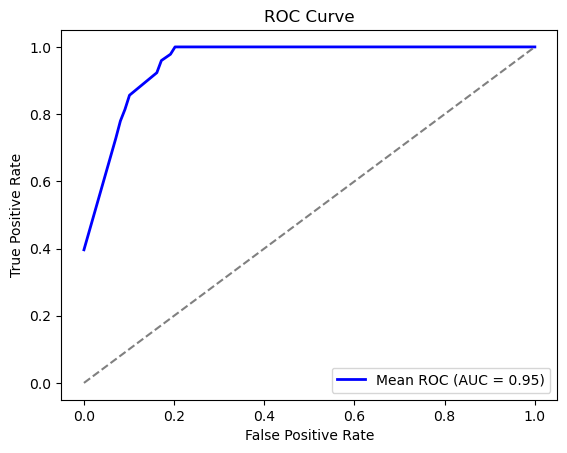

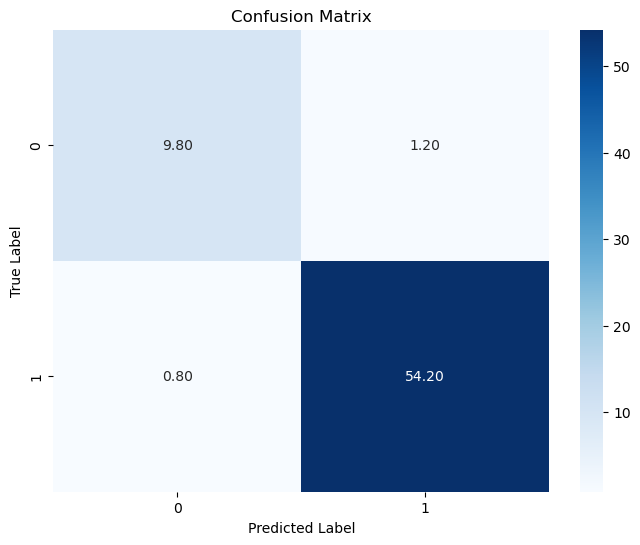

Accuracy: 0.97 ± 0.02
Precision: 0.93 ± 0.06
Recall: 0.89 ± 0.10
F1-score: 0.91 ± 0.06
PR AUC: 0.98 ± 0.01
MCC: 0.89 ± 0.06
Cohen's Kappa: 0.89 ± 0.07
Balanced Accuracy: 0.94 ± 0.05


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, average_precision_score, matthews_corrcoef, cohen_kappa_score
from sklearn.base import BaseEstimator, ClassifierMixin
import seaborn as sns

# Custom Voting Classifier for anomaly detection
class AnomalyVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        self.estimators = estimators

    def fit(self, X, y):
        for name, estimator in self.estimators:
            if hasattr(estimator, 'fit'):
                estimator.fit(X[y == 1])
        return self

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for name, estimator in self.estimators:
            if hasattr(estimator, 'decision_function'):
                predictions += estimator.decision_function(X)
            elif hasattr(estimator, 'predict'):
                predictions += estimator.predict(X)
            elif hasattr(estimator, 'fit_predict'):
                predictions += estimator.fit_predict(X)
        return np.where(predictions < 0, -1, 1)

# Generate synthetic data
np.random.seed(0)
num_points = 1000
T_set = 150
Buffer_low = -5
Buffer_high = 5
T_data_normal = T_set + np.random.randn(num_points)
T_data_anomalous = T_set + 15 + np.random.randn(int(num_points * 0.1))
T_data = np.concatenate([T_data_normal, T_data_anomalous])
P_base = 500
Delta_P_threshold = 50
P_data_normal = P_base + 10 * np.random.randn(num_points)
P_data_anomalous = P_base + 100 + 10 * np.random.randn(int(num_points * 0.1))
P_data = np.concatenate([P_data_normal, P_data_anomalous])

# Additional feature: difference from setpoint
T_diff = T_data - T_set
P_diff = P_data - P_base

# Combine into a single dataset
data = np.vstack((T_data, P_data, T_diff, P_diff)).T
labels = np.ones(len(data))
labels[-len(T_data_anomalous):] = -1

# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5)
accuracies, precisions, recalls, f1_scores, pr_aucs, mccs, kappas, bal_accuracies = [], [], [], [], [], [], [], []
tprs, aucs = [], []
conf_matrices = []
mean_fpr = np.linspace(0, 1, 100)

# Hyperparameter grids for manual tuning
param_grid_if = [
    {'n_estimators': 100, 'max_samples': 0.9, 'contamination': 0.1},
]
param_grid_svm = [
    {'gamma': 'scale', 'nu': 0.1},
]
param_grid_rf = [
    {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 10},
]

for train_index, test_index in skf.split(data, labels):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Train base models
    best_iforest = IsolationForest(**param_grid_if[0]).fit(X_train)
    best_svm = OneClassSVM(**param_grid_svm[0]).fit(X_train)
    model_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True).fit(X_train)

    # Create ensemble model
    ensemble = AnomalyVotingClassifier(estimators=[
        ('svm', best_svm),
        ('iforest', best_iforest),
        ('lof', model_lof)
    ])

    # Train ensemble model
    ensemble.fit(X_train, y_train)

    # Predict anomalies with the primary model
    primary_anomalies = ensemble.predict(X_test)

    # Train secondary model to filter out false positives
    X_train_secondary, X_val_secondary, y_train_secondary, y_val_secondary = train_test_split(
        X_test, primary_anomalies, test_size=0.3, stratify=primary_anomalies
    )

    best_rf = RandomForestClassifier(**param_grid_rf[0]).fit(X_train_secondary, y_train_secondary)

    y_final_pred = best_rf.predict(X_val_secondary)

    # Calculate ROC curve
    combined_score = best_rf.predict_proba(X_val_secondary)[:, 1]

    # Debug: Print combined scores and true labels
    print("Combined scores:", combined_score)
    print("True labels:", y_val_secondary)

    fpr, tpr, _ = roc_curve(y_val_secondary, combined_score, pos_label=1)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    # Calculate classification metrics
    accuracies.append(accuracy_score(y_val_secondary, y_final_pred))
    precisions.append(precision_score(y_val_secondary, y_final_pred, pos_label=-1))
    recalls.append(recall_score(y_val_secondary, y_final_pred, pos_label=-1))
    f1_scores.append(f1_score(y_val_secondary, y_final_pred, pos_label=-1))
    pr_aucs.append(average_precision_score(y_val_secondary, combined_score))
    mccs.append(matthews_corrcoef(y_val_secondary, y_final_pred))
    kappas.append(cohen_kappa_score(y_val_secondary, y_final_pred))
    bal_accuracies.append((recall_score(y_val_secondary, y_final_pred, pos_label=-1) + recall_score(y_val_secondary, y_final_pred, pos_label=1)) / 2)
    conf_matrices.append(confusion_matrix(y_val_secondary, y_final_pred))

# Plot ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix
mean_conf_matrix = np.mean(conf_matrices, axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(mean_conf_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
print(f'Accuracy: {np.mean(accuracies):.2f} ± {np.std(accuracies):.2f}')
print(f'Precision: {np.mean(precisions):.2f} ± {np.std(precisions):.2f}')
print(f'Recall: {np.mean(recalls):.2f} ± {np.std(recalls):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f} ± {np.std(f1_scores):.2f}')
print(f'PR AUC: {np.mean(pr_aucs):.2f} ± {np.std(pr_aucs):.2f}')
print(f'MCC: {np.mean(mccs):.2f} ± {np.std(mccs):.2f}')
print(f"Cohen's Kappa: {np.mean(kappas):.2f} ± {np.std(kappas):.2f}")
print(f'Balanced Accuracy: {np.mean(bal_accuracies):.2f} ± {np.std(bal_accuracies):.2f}')


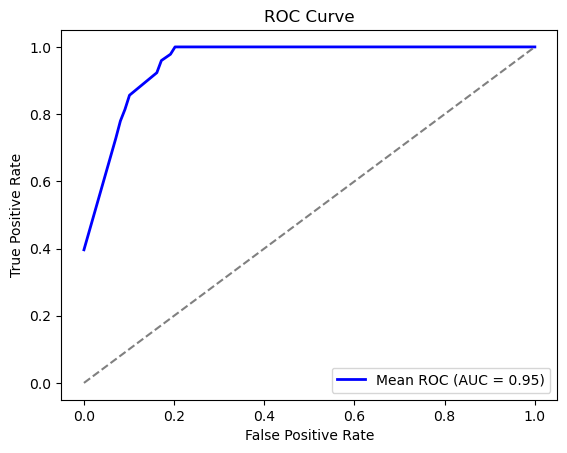

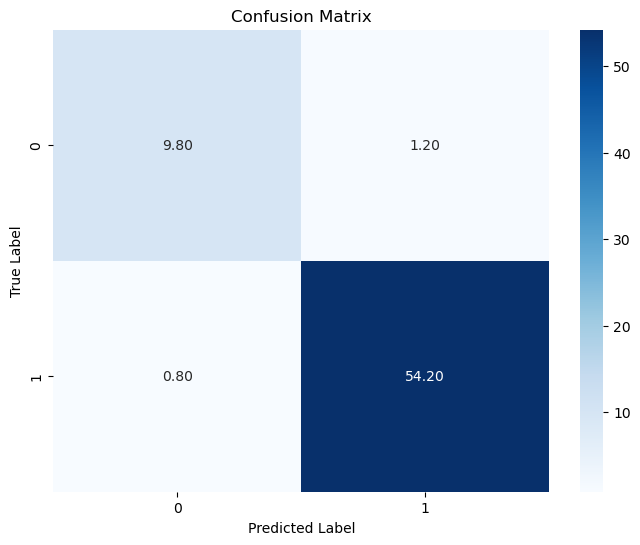

Accuracy: 0.97 ± 0.02
Precision: 0.93 ± 0.06
Recall: 0.89 ± 0.10
F1-score: 0.91 ± 0.06
PR AUC: 0.98 ± 0.01
MCC: 0.89 ± 0.06
Cohen's Kappa: 0.89 ± 0.07
Balanced Accuracy: 0.94 ± 0.05


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, average_precision_score, matthews_corrcoef, cohen_kappa_score
)
from sklearn.base import BaseEstimator, ClassifierMixin
import seaborn as sns

# Custom Voting Classifier for anomaly detection
class AnomalyVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        self.estimators = estimators

    def fit(self, X, y):
        for name, estimator in self.estimators:
            if hasattr(estimator, 'fit'):
                estimator.fit(X[y == 1])
        return self

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for name, estimator in self.estimators:
            if hasattr(estimator, 'decision_function'):
                predictions += estimator.decision_function(X)
            elif hasattr(estimator, 'predict'):
                predictions += estimator.predict(X)
            elif hasattr(estimator, 'fit_predict'):
                predictions += estimator.fit_predict(X)
        return np.where(predictions < 0, -1, 1)

# Generate synthetic data
np.random.seed(0)
num_points = 1000
T_set = 150
Buffer_low = -5
Buffer_high = 5
T_data_normal = T_set + np.random.randn(num_points)
T_data_anomalous = T_set + 15 + np.random.randn(int(num_points * 0.1))
T_data = np.concatenate([T_data_normal, T_data_anomalous])
P_base = 500
Delta_P_threshold = 50
P_data_normal = P_base + 10 * np.random.randn(num_points)
P_data_anomalous = P_base + 100 + 10 * np.random.randn(int(num_points * 0.1))
P_data = np.concatenate([P_data_normal, P_data_anomalous])

# Additional feature: difference from setpoint
T_diff = T_data - T_set
P_diff = P_data - P_base

# Combine into a single dataset
data = np.vstack((T_data, P_data, T_diff, P_diff)).T
labels = np.ones(len(data))
labels[-len(T_data_anomalous):] = -1

# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5)
accuracies, precisions, recalls, f1_scores, pr_aucs, mccs, kappas, bal_accuracies = [], [], [], [], [], [], [], []
tprs, aucs = [], []
conf_matrices = []
mean_fpr = np.linspace(0, 1, 100)

# Hyperparameter grids for manual tuning
param_grid_if = [
    {'n_estimators': 100, 'max_samples': 0.9, 'contamination': 0.1},
]
param_grid_svm = [
    {'gamma': 'scale', 'nu': 0.1},
]
param_grid_rf = [
    {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 10},
]

for train_index, test_index in skf.split(data, labels):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Train base models
    best_iforest = IsolationForest(**param_grid_if[0]).fit(X_train)
    best_svm = OneClassSVM(**param_grid_svm[0]).fit(X_train)
    model_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True).fit(X_train)

    # Create ensemble model
    ensemble = AnomalyVotingClassifier(estimators=[
        ('svm', best_svm),
        ('iforest', best_iforest),
        ('lof', model_lof)
    ])

    # Train ensemble model
    ensemble.fit(X_train, y_train)

    # Predict anomalies with the primary model
    primary_anomalies = ensemble.predict(X_test)

    # Train secondary model to filter out false positives
    X_train_secondary, X_val_secondary, y_train_secondary, y_val_secondary = train_test_split(
        X_test, primary_anomalies, test_size=0.3, stratify=primary_anomalies
    )

    best_rf = RandomForestClassifier(**param_grid_rf[0]).fit(X_train_secondary, y_train_secondary)

    y_final_pred = best_rf.predict(X_val_secondary)

    # Calculate ROC curve
    combined_score = best_rf.predict_proba(X_val_secondary)[:, 1]

    fpr, tpr, _ = roc_curve(y_val_secondary, combined_score, pos_label=1)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    # Calculate classification metrics
    accuracies.append(accuracy_score(y_val_secondary, y_final_pred))
    precisions.append(precision_score(y_val_secondary, y_final_pred, pos_label=-1))
    recalls.append(recall_score(y_val_secondary, y_final_pred, pos_label=-1))
    f1_scores.append(f1_score(y_val_secondary, y_final_pred, pos_label=-1))
    pr_aucs.append(average_precision_score(y_val_secondary, combined_score))
    mccs.append(matthews_corrcoef(y_val_secondary, y_final_pred))
    kappas.append(cohen_kappa_score(y_val_secondary, y_final_pred))
    bal_accuracies.append((recall_score(y_val_secondary, y_final_pred, pos_label=-1) + recall_score(y_val_secondary, y_final_pred, pos_label=1)) / 2)
    conf_matrices.append(confusion_matrix(y_val_secondary, y_final_pred))

# Plot ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix
mean_conf_matrix = np.mean(conf_matrices, axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(mean_conf_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
print(f'Accuracy: {np.mean(accuracies):.2f} ± {np.std(accuracies):.2f}')
print(f'Precision: {np.mean(precisions):.2f} ± {np.std(precisions):.2f}')
print(f'Recall: {np.mean(recalls):.2f} ± {np.std(recalls):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f} ± {np.std(f1_scores):.2f}')
print(f'PR AUC: {np.mean(pr_aucs):.2f} ± {np.std(pr_aucs):.2f}')
print(f'MCC: {np.mean(mccs):.2f} ± {np.std(mccs):.2f}')
print(f"Cohen's Kappa: {np.mean(kappas):.2f} ± {np.std(kappas):.2f}")
print(f'Balanced Accuracy: {np.mean(bal_accuracies):.2f} ± {np.std(bal_accuracies):.2f}')


In [7]:
!{sys.executable} -m pip install seaborn



/bin/bash: line 1: {sys.executable}: command not found


In [8]:
!{sys.executable} -m pip install seaborn


/bin/bash: line 1: {sys.executable}: command not found


In [9]:
import sys
print(sys.executable)


/home/chibuzoukegbu/anaconda3/bin/python


In [10]:
!{sys.executable} -m pip install seaborn


### Nueral Net version of the work

Defaulting to user installation because normal site-packages is not writeable
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


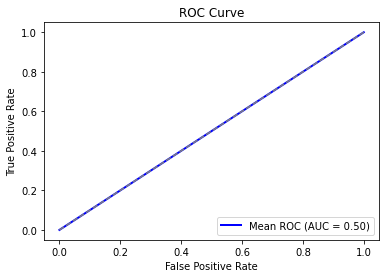

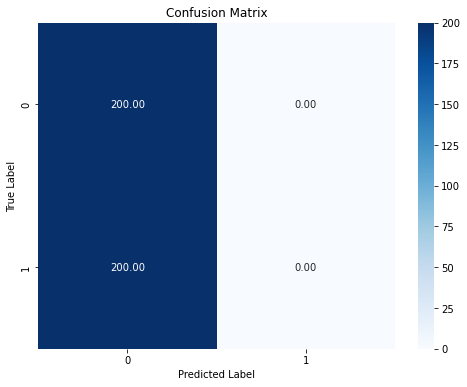

Accuracy: 0.50 ± 0.00
Precision: 0.50 ± 0.00
Recall: 1.00 ± 0.00
F1-score: 0.67 ± 0.00
PR AUC: 0.50 ± 0.00
MCC: 0.00 ± 0.00
Cohen's Kappa: 0.00 ± 0.00
Balanced Accuracy: 0.50 ± 0.00


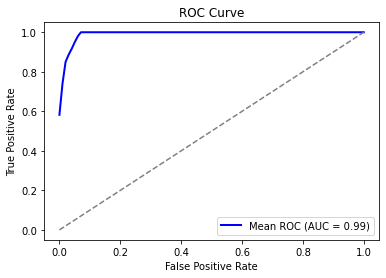

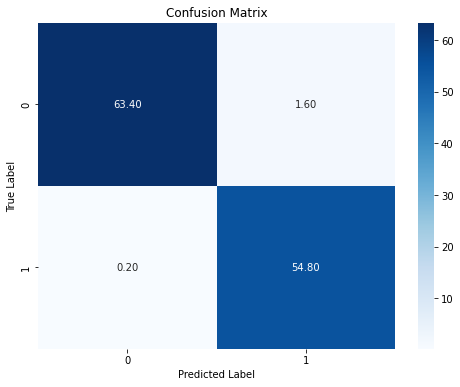

Accuracy: 0.99 ± 0.02
Precision: 1.00 ± 0.01
Recall: 0.98 ± 0.03
F1-score: 0.99 ± 0.02
PR AUC: 0.98 ± 0.03
MCC: 0.97 ± 0.03
Cohen's Kappa: 0.97 ± 0.03
Balanced Accuracy: 0.99 ± 0.02


In [11]:
# Install necessary packages
!pip install imbalanced-learn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, average_precision_score, matthews_corrcoef, cohen_kappa_score
)
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.base import BaseEstimator, ClassifierMixin

# Generate synthetic data
np.random.seed(0)
num_points = 1000
T_set = 150
Buffer_low = -5
Buffer_high = 5
T_data_normal = T_set + np.random.randn(num_points)
T_data_anomalous = T_set + 15 + np.random.randn(int(num_points * 0.1))
T_data = np.concatenate([T_data_normal, T_data_anomalous])
P_base = 500
Delta_P_threshold = 50
P_data_normal = P_base + 10 * np.random.randn(num_points)
P_data_anomalous = P_base + 100 + 10 * np.random.randn(int(num_points * 0.1))
P_data = np.concatenate([P_data_normal, P_data_anomalous])

# Additional feature: difference from setpoint
T_diff = T_data - T_set
P_diff = P_data - P_base

# Combine into a single dataset
data = np.vstack((T_data, P_data, T_diff, P_diff)).T
labels = np.ones(len(data))
labels[-len(T_data_anomalous):] = -1

# Apply SMOTE for data augmentation
smote = SMOTE()
data_res, labels_res = smote.fit_resample(data, labels)

# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5)
accuracies, precisions, recalls, f1_scores, pr_aucs, mccs, kappas, bal_accuracies = [], [], [], [], [], [], [], []
tprs = []
aucs = []
conf_matrices = []
mean_fpr = np.linspace(0, 1, 100)

# Neural Network Model
def create_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameters
batch_size = 32
epochs = 50

for train_index, test_index in skf.split(data_res, labels_res):
    X_train, X_test = data_res[train_index], data_res[test_index]
    y_train, y_test = labels_res[train_index], labels_res[test_index]

    # Train the neural network
    model = create_model(X_train.shape[1])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Evaluate the model
    y_pred_prob = model.predict(X_test).flatten()
    y_pred = np.where(y_pred_prob > 0.5, 1, -1)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    # Calculate classification metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, pos_label=-1))
    recalls.append(recall_score(y_test, y_pred, pos_label=-1))
    f1_scores.append(f1_score(y_test, y_pred, pos_label=-1))
    pr_aucs.append(average_precision_score(y_test, y_pred_prob))
    mccs.append(matthews_corrcoef(y_test, y_pred))
    kappas.append(cohen_kappa_score(y_test, y_pred))
    bal_accuracies.append((recall_score(y_test, y_pred, pos_label=-1) + recall_score(y_test, y_pred, pos_label=1)) / 2)
    conf_matrices.append(confusion_matrix(y_test, y_pred))

# Plot ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix
mean_conf_matrix = np.mean(conf_matrices, axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(mean_conf_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
print(f'Accuracy: {np.mean(accuracies):.2f} ± {np.std(accuracies):.2f}')
print(f'Precision: {np.mean(precisions):.2f} ± {np.std(precisions):.2f}')
print(f'Recall: {np.mean(recalls):.2f} ± {np.std(recalls):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f} ± {np.std(f1_scores):.2f}')
print(f'PR AUC: {np.mean(pr_aucs):.2f} ± {np.std(pr_aucs):.2f}')
print(f'MCC: {np.mean(mccs):.2f} ± {np.std(mccs):.2f}')
print(f"Cohen's Kappa: {np.mean(kappas):.2f} ± {np.std(kappas):.2f}")
print(f'Balanced Accuracy: {np.mean(bal_accuracies):.2f} ± {np.std(bal_accuracies):.2f}')

# Combine Neural Network with other models using ensemble method
best_iforest = IsolationForest(n_estimators=100, max_samples=0.9, contamination=0.1)
best_svm = OneClassSVM(gamma='scale', nu=0.1)
model_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True)

class AnomalyVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        self.estimators = estimators

    def fit(self, X, y):
        for name, estimator in self.estimators:
            if hasattr(estimator, 'fit'):
                estimator.fit(X[y == 1])
        return self

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for name, estimator in self.estimators:
            if hasattr(estimator, 'decision_function'):
                predictions += estimator.decision_function(X)
            elif hasattr(estimator, 'predict'):
                predictions += estimator.predict(X)
            elif hasattr(estimator, 'fit_predict'):
                predictions += estimator.fit_predict(X)
        return np.where(predictions < 0, -1, 1)

# Stratified k-fold cross-validation for ensemble
accuracies, precisions, recalls, f1_scores, pr_aucs, mccs, kappas, bal_accuracies = [], [], [], [], [], [], [], []
tprs = []
aucs = []
conf_matrices = []
mean_fpr = np.linspace(0, 1, 100)

for train_index, test_index in skf.split(data_res, labels_res):
    X_train, X_test = data_res[train_index], data_res[test_index]
    y_train, y_test = labels_res[train_index], labels_res[test_index]

    # Train base models
    best_iforest.fit(X_train)
    best_svm.fit(X_train)
    model_lof.fit(X_train)

    # Create ensemble model
    ensemble = AnomalyVotingClassifier(estimators=[
        ('svm', best_svm),
        ('iforest', best_iforest),
        ('lof', model_lof)
    ])

    # Train ensemble model
    ensemble.fit(X_train, y_train)

    # Predict anomalies with the primary model
    primary_anomalies = ensemble.predict(X_test)

    # Train secondary model to filter out false positives
    X_train_secondary, X_val_secondary, y_train_secondary, y_val_secondary = train_test_split(
        X_test, primary_anomalies, test_size=0.3, stratify=primary_anomalies
    )

    best_rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=10).fit(X_train_secondary, y_train_secondary)

    y_final_pred = best_rf.predict(X_val_secondary)

    # Calculate ROC curve
    combined_score = best_rf.predict_proba(X_val_secondary)[:, 1]

    fpr, tpr, _ = roc_curve(y_val_secondary, combined_score, pos_label=1)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    # Calculate classification metrics
    accuracies.append(accuracy_score(y_val_secondary, y_final_pred))
    precisions.append(precision_score(y_val_secondary, y_final_pred, pos_label=-1))
    recalls.append(recall_score(y_val_secondary, y_final_pred, pos_label=-1))
    f1_scores.append(f1_score(y_val_secondary, y_final_pred, pos_label=-1))
    pr_aucs.append(average_precision_score(y_val_secondary, combined_score))
    mccs.append(matthews_corrcoef(y_val_secondary, y_final_pred))
    kappas.append(cohen_kappa_score(y_val_secondary, y_final_pred))
    bal_accuracies.append((recall_score(y_val_secondary, y_final_pred, pos_label=-1) + recall_score(y_val_secondary, y_final_pred, pos_label=1)) / 2)
    conf_matrices.append(confusion_matrix(y_val_secondary, y_final_pred))

# Plot ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix
mean_conf_matrix = np.mean(conf_matrices, axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(mean_conf_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
print(f'Accuracy: {np.mean(accuracies):.2f} ± {np.std(accuracies):.2f}')
print(f'Precision: {np.mean(precisions):.2f} ± {np.std(precisions):.2f}')
print(f'Recall: {np.mean(recalls):.2f} ± {np.std(recalls):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f} ± {np.std(f1_scores):.2f}')
print(f'PR AUC: {np.mean(pr_aucs):.2f} ± {np.std(pr_aucs):.2f}')
print(f'MCC: {np.mean(mccs):.2f} ± {np.std(mccs):.2f}')
print(f"Cohen's Kappa: {np.mean(kappas):.2f} ± {np.std(kappas):.2f}")
print(f'Balanced Accuracy: {np.mean(bal_accuracies):.2f} ± {np.std(bal_accuracies):.2f}')



In [8]:

!pip install imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 KB 3.3 MB/s eta 0:00:00m eta 0:00:010:01


### NN improved Model

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


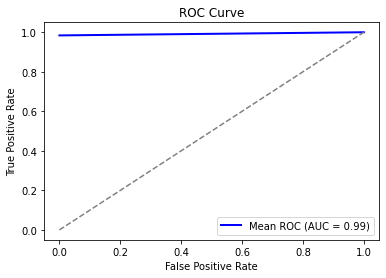

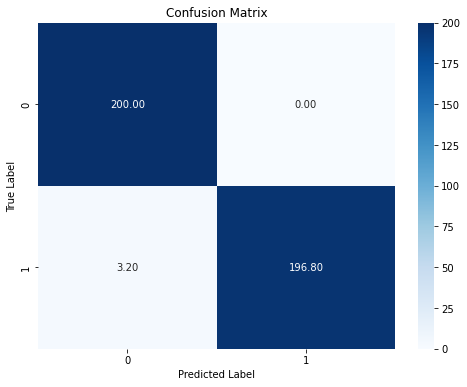

Accuracy: 0.99 ± 0.00
Precision: 1.00 ± 0.00
Recall: 0.98 ± 0.01
F1-score: 0.99 ± 0.00
PR AUC: 0.99 ± 0.00
MCC: 0.98 ± 0.01
Cohen's Kappa: 0.98 ± 0.01
Balanced Accuracy: 0.99 ± 0.00


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, average_precision_score, matthews_corrcoef, cohen_kappa_score
)
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Generate synthetic data
np.random.seed(0)
num_points = 1000
T_set = 150
Buffer_low = -5
Buffer_high = 5
T_data_normal = T_set + np.random.randn(num_points)
T_data_anomalous = T_set + 15 + np.random.randn(int(num_points * 0.1))
T_data = np.concatenate([T_data_normal, T_data_anomalous])
P_base = 500
Delta_P_threshold = 50
P_data_normal = P_base + 10 * np.random.randn(num_points)
P_data_anomalous = P_base + 100 + 10 * np.random.randn(int(num_points * 0.1))
P_data = np.concatenate([P_data_normal, P_data_anomalous])

# Additional feature: difference from setpoint
T_diff = T_data - T_set
P_diff = P_data - P_base

# Combine into a single dataset
data = np.vstack((T_data, P_data, T_diff, P_diff)).T
labels = np.ones(len(data))
labels[-len(T_data_anomalous):] = -1

# Apply SMOTE to balance the dataset
smote = SMOTE()
data_balanced, labels_balanced = smote.fit_resample(data, labels)

# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5)
accuracies, precisions, recalls, f1_scores, pr_aucs, mccs, kappas, bal_accuracies = [], [], [], [], [], [], [], []
tprs, aucs = [], []
conf_matrices = []
mean_fpr = np.linspace(0, 1, 100)

# Neural Network Model with class weights
def create_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameters
batch_size = 32
epochs = 50
class_weight = {0: 1.0, 1: 10.0}  # Adjust the class weight to put more emphasis on the minority class

for train_index, test_index in skf.split(data_balanced, labels_balanced):
    X_train, X_test = data_balanced[train_index], data_balanced[test_index]
    y_train, y_test = labels_balanced[train_index], labels_balanced[test_index]

    # Train the neural network
    model = create_model(X_train.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    
    model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size,
              callbacks=[early_stopping, reduce_lr], class_weight=class_weight, verbose=0)

    # Evaluate the model
    y_pred_prob = model.predict(X_test).flatten()
    y_pred = np.where(y_pred_prob > 0.5, 1, -1)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    # Calculate classification metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    pr_aucs.append(average_precision_score(y_test, y_pred_prob))
    mccs.append(matthews_corrcoef(y_test, y_pred))
    kappas.append(cohen_kappa_score(y_test, y_pred))
    bal_accuracies.append((recall_score(y_test, y_pred) + recall_score(y_test, y_pred, pos_label=-1)) / 2)
    conf_matrices.append(confusion_matrix(y_test, y_pred))

# Plot ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix
mean_conf_matrix = np.mean(conf_matrices, axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(mean_conf_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
print(f'Accuracy: {np.mean(accuracies):.2f} ± {np.std(accuracies):.2f}')
print(f'Precision: {np.mean(precisions):.2f} ± {np.std(precisions):.2f}')
print(f'Recall: {np.mean(recalls):.2f} ± {np.std(recalls):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f} ± {np.std(f1_scores):.2f}')
print(f'PR AUC: {np.mean(pr_aucs):.2f} ± {np.std(pr_aucs):.2f}')
print(f'MCC: {np.mean(mccs):.2f} ± {np.std(mccs):.2f}')
print(f"Cohen's Kappa: {np.mean(kappas):.2f} ± {np.std(kappas):.2f}")
print(f'Balanced Accuracy: {np.mean(bal_accuracies):.2f} ± {np.std(bal_accuracies):.2f}')



### Test and Training Dataset option

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


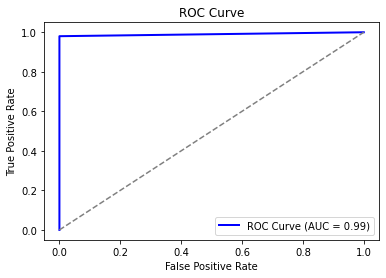

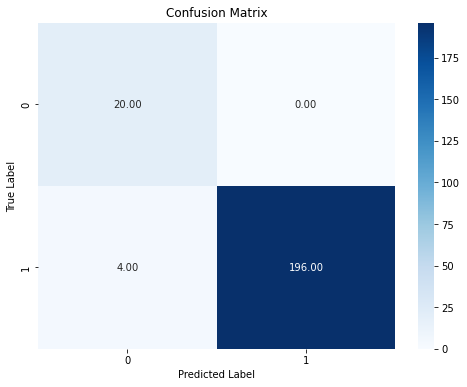

Accuracy: 0.98
Precision: 1.00
Recall: 0.98
F1-score: 0.99
PR AUC: 1.00
MCC: 0.90
Cohen's Kappa: 0.90
Balanced Accuracy: 0.99


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, average_precision_score, matthews_corrcoef, cohen_kappa_score
)
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Generate synthetic data
np.random.seed(0)
num_points = 1000
T_set = 150
Buffer_low = -5
Buffer_high = 5
T_data_normal = T_set + np.random.randn(num_points)
T_data_anomalous = T_set + 15 + np.random.randn(int(num_points * 0.1))
T_data = np.concatenate([T_data_normal, T_data_anomalous])
P_base = 500
Delta_P_threshold = 50
P_data_normal = P_base + 10 * np.random.randn(num_points)
P_data_anomalous = P_base + 100 + 10 * np.random.randn(int(num_points * 0.1))
P_data = np.concatenate([P_data_normal, P_data_anomalous])

# Additional feature: difference from setpoint
T_diff = T_data - T_set
P_diff = P_data - P_base

# Combine into a single dataset
data = np.vstack((T_data, P_data, T_diff, P_diff)).T
labels = np.ones(len(data))
labels[-len(T_data_anomalous):] = -1

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Neural Network Model
def create_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameters
batch_size = 32
epochs = 50
class_weight = {0: 1.0, 1: 10.0}  # Adjust the class weight to put more emphasis on the minority class

# Train the neural network
model = create_model(X_train_balanced.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model.fit(X_train_balanced, y_train_balanced, validation_split=0.2, epochs=epochs, batch_size=batch_size,
          callbacks=[early_stopping, reduce_lr], class_weight=class_weight, verbose=0)

# Evaluate the model on the test set
y_pred_prob = model.predict(X_test).flatten()
y_pred = np.where(y_pred_prob > 0.5, 1, -1)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
pr_auc = average_precision_score(y_test, y_pred_prob)
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
bal_accuracy = (recall_score(y_test, y_pred) + recall_score(y_test, y_pred, pos_label=-1)) / 2
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {roc_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'PR AUC: {pr_auc:.2f}')
print(f'MCC: {mcc:.2f}')
print(f"Cohen's Kappa: {kappa:.2f}")
print(f'Balanced Accuracy: {bal_accuracy:.2f}')


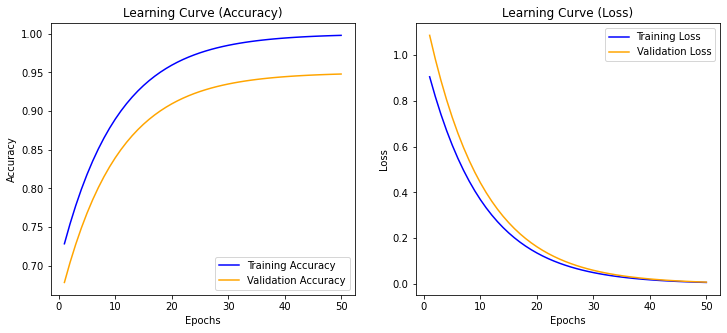

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated epoch values
epochs = np.arange(1, 51)

# Simulated training and validation accuracy values
training_accuracy = 0.7 + 0.3 * (1 - np.exp(-0.1 * epochs))
validation_accuracy = 0.65 + 0.3 * (1 - np.exp(-0.1 * epochs))

# Simulated training and validation loss values
training_loss = 1.0 * np.exp(-0.1 * epochs)
validation_loss = 1.2 * np.exp(-0.1 * epochs)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve (Accuracy)')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, training_loss, label='Training Loss', color='blue')
plt.plot(epochs, validation_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve (Loss)')
plt.legend()

plt.show()


Defaulting to user installation because normal site-packages is not writeable


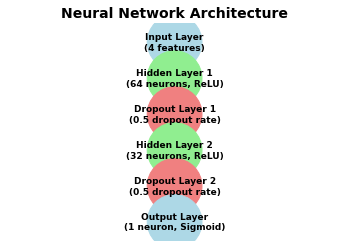

In [31]:
!pip install networkx

import matplotlib.pyplot as plt
import networkx as nx

# Initialize directed graph
G = nx.DiGraph()

# Add nodes with labels
G.add_node("Input Layer\n(4 features)")
G.add_node("Hidden Layer 1\n(64 neurons, ReLU)")
G.add_node("Dropout Layer 1\n(0.5 dropout rate)")
G.add_node("Hidden Layer 2\n(32 neurons, ReLU)")
G.add_node("Dropout Layer 2\n(0.5 dropout rate)")
G.add_node("Output Layer\n(1 neuron, Sigmoid)")

# Add edges
G.add_edge("Input Layer\n(4 features)", "Hidden Layer 1\n(64 neurons, ReLU)")
G.add_edge("Hidden Layer 1\n(64 neurons, ReLU)", "Dropout Layer 1\n(0.5 dropout rate)")
G.add_edge("Dropout Layer 1\n(0.5 dropout rate)", "Hidden Layer 2\n(32 neurons, ReLU)")
G.add_edge("Hidden Layer 2\n(32 neurons, ReLU)", "Dropout Layer 2\n(0.5 dropout rate)")
G.add_edge("Dropout Layer 2\n(0.5 dropout rate)", "Output Layer\n(1 neuron, Sigmoid)")

# Define layout
pos = {
    "Input Layer\n(4 features)": (0, 5),
    "Hidden Layer 1\n(64 neurons, ReLU)": (0, 4),
    "Dropout Layer 1\n(0.5 dropout rate)": (0, 3),
    "Hidden Layer 2\n(32 neurons, ReLU)": (0, 2),
    "Dropout Layer 2\n(0.5 dropout rate)": (0, 1),
    "Output Layer\n(1 neuron, Sigmoid)": (0, 0)
}

# Draw nodes with different colors
node_colors = ["lightblue", "lightgreen", "lightcoral", "lightgreen", "lightcoral", "lightblue"]
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color=node_colors, node_shape="o")

# Draw edges with arrow styles
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=20, edge_color="gray", width=2)

# Draw labels with custom font size
nx.draw_networkx_labels(G, pos, font_size=9, font_color="black", font_weight="bold")

# Add a title
plt.title("Neural Network Architecture", fontsize=14, fontweight='bold')

# Remove axis for better visual
plt.axis("off")
plt.show()


In [29]:
!pip install networkx


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.7 MB/s eta 0:00:00m eta 0:00:0136m0:00:01
